<a href="https://colab.research.google.com/github/respect5716/deep-learning-paper-implementation/blob/main/02_Vision/pSp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pSp

## 0. Info

### Paper
* title: Encoding in Style: a StyleGAN Encoder for Image-to-Image Translation
* author: Elad Richardson et al.
* url: https://arxiv.org/abs/2008.00951

### Features
* dataset: FFHQ (256)

### Reference
* https://github.com/eladrich/pixel2style2pixel

## 1. Setup

In [1]:
!pip install -q gdown lpips ninja

     |████████████████████████████████| 53 kB 2.0 MB/s 


In [8]:
import os
import math
import random
import easydict
import itertools
import numpy as np
from glob import glob
from PIL import Image
from tqdm.auto import tqdm
from collections import namedtuple, OrderedDict

import lpips
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import cpp_extension

import torchvision
import torchvision.transforms as T

In [ ]:
# prepare cpp files
!wget https://raw.githubusercontent.com/eladrich/pixel2style2pixel/master/models/stylegan2/op/fused_bias_act.cpp
!wget https://raw.githubusercontent.com/eladrich/pixel2style2pixel/master/models/stylegan2/op/fused_bias_act_kernel.cu
!wget https://raw.githubusercontent.com/eladrich/pixel2style2pixel/master/models/stylegan2/op/upfirdn2d.cpp
!wget https://raw.githubusercontent.com/eladrich/pixel2style2pixel/master/models/stylegan2/op/upfirdn2d_kernel.cu

# prepare pretrained weights
!gdown https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT # FFHQ StyleGAN
!gdown https://drive.google.com/uc?id=1KW7bjndL3QG3sxBbZxreGHigcCCpsDgn # IR-SE50 model

In [7]:
cfg = easydict.EasyDict(
    dataset = 'ffhq-256',
    img_size = 256,
    
    batch_size = 2,
    lr = 1e-4,
    num_training_steps = 10000,

    lambda_l2 = 1.0,
    lambda_id = 0.1,
    lambda_lpips = 0.8,
    lambda_wnorm = 0.,

    device = 'cuda',
    dataset_dir = '/content/drive/Shareddrives/dataset',
)

## 2. Data

### 2.1. Load

In [9]:
data_path = os.path.join(cfg.dataset_dir, f'{cfg.dataset}.zip')
!unzip -q "{data_path}" -d 'data'

### 2.2. Dataset and Dataloader

In [16]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, datadir, transform):
        self.files = files = glob(f'{datadir}/*.jpg')
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        f = self.files[idx]
        img = Image.open(f).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [17]:
train_transform = T.Compose([
    T.Resize(cfg.img_size),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = T.Compose([
    T.Resize(cfg.img_size),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [18]:
train_dataset = Dataset('data/images', train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)

test_dataset = Dataset('data/images', test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=True)

In [19]:
inputs = next(iter(train_loader))
inputs.shape

torch.Size([2, 3, 256, 256])

## 3. Model

### 3.1. StyleGAN

In [27]:
# load cpp ops
fused = cpp_extension.load('fused', sources=['fused_bias_act.cpp', 'fused_bias_act_kernel.cu'])
upfirdn2d_op = cpp_extension.load('upfirdn2d', sources=['upfirdn2d.cpp', 'upfirdn2d_kernel.cu'])

In [28]:
# ops
class FusedLeakyReLUFunctionBackward(torch.autograd.Function):
    @staticmethod
    def forward(ctx, grad_output, out, negative_slope, scale):
        ctx.save_for_backward(out)
        ctx.negative_slope = negative_slope
        ctx.scale = scale

        empty = grad_output.new_empty(0)
        grad_input = fused.fused_bias_act(grad_output, empty, out, 3, 1, negative_slope, scale)
        dim = [0]

        if grad_input.ndim > 2:
            dim += list(range(2, grad_input.ndim))
        grad_bias = grad_input.sum(dim).detach()
        return grad_input, grad_bias

    @staticmethod
    def backward(ctx, gradgrad_input, gradgrad_bias):
        out, = ctx.saved_tensors
        gradgrad_out = fused.fused_bias_act(gradgrad_input, gradgrad_bias, out, 3, 1, ctx.negative_slope, ctx.scale)
        return gradgrad_out, None, None, None


class FusedLeakyReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, bias, negative_slope, scale):
        empty = input.new_empty(0)
        out = fused.fused_bias_act(input, bias, empty, 3, 0, negative_slope, scale)
        ctx.save_for_backward(out)
        ctx.negative_slope = negative_slope
        ctx.scale = scale
        return out

    @staticmethod
    def backward(ctx, grad_output):
        out, = ctx.saved_tensors
        grad_input, grad_bias = FusedLeakyReLUFunctionBackward.apply(grad_output, out, ctx.negative_slope, ctx.scale)
        return grad_input, grad_bias, None, None


class FusedLeakyReLU(nn.Module):
    def __init__(self, channel, negative_slope=0.2, scale=2 ** 0.5):
        super().__init__()
        self.bias = nn.Parameter(torch.zeros(channel))
        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        return fused_leaky_relu(input, self.bias, self.negative_slope, self.scale)


def fused_leaky_relu(input, bias, negative_slope=0.2, scale=2 ** 0.5):
    return FusedLeakyReLUFunction.apply(input, bias, negative_slope, scale)


class UpFirDn2dBackward(torch.autograd.Function):
    @staticmethod
    def forward(ctx, grad_output, kernel, grad_kernel, up, down, pad, g_pad, in_size, out_size):
        up_x, up_y = up
        down_x, down_y = down
        g_pad_x0, g_pad_x1, g_pad_y0, g_pad_y1 = g_pad

        grad_output = grad_output.reshape(-1, out_size[0], out_size[1], 1)
        grad_input = upfirdn2d_op.upfirdn2d(
            grad_output,
            grad_kernel,
            down_x,
            down_y,
            up_x,
            up_y,
            g_pad_x0,
            g_pad_x1,
            g_pad_y0,
            g_pad_y1,
        )
        grad_input = grad_input.view(in_size[0], in_size[1], in_size[2], in_size[3])

        ctx.save_for_backward(kernel)

        pad_x0, pad_x1, pad_y0, pad_y1 = pad
        ctx.up_x = up_x
        ctx.up_y = up_y
        ctx.down_x = down_x
        ctx.down_y = down_y
        ctx.pad_x0 = pad_x0
        ctx.pad_x1 = pad_x1
        ctx.pad_y0 = pad_y0
        ctx.pad_y1 = pad_y1
        ctx.in_size = in_size
        ctx.out_size = out_size
        return grad_input

    @staticmethod
    def backward(ctx, gradgrad_input):
        kernel, = ctx.saved_tensors
        gradgrad_input = gradgrad_input.reshape(-1, ctx.in_size[2], ctx.in_size[3], 1)
        gradgrad_out = upfirdn2d_op.upfirdn2d(
            gradgrad_input,
            kernel,
            ctx.up_x,
            ctx.up_y,
            ctx.down_x,
            ctx.down_y,
            ctx.pad_x0,
            ctx.pad_x1,
            ctx.pad_y0,
            ctx.pad_y1,
        )
        # gradgrad_out = gradgrad_out.view(ctx.in_size[0], ctx.out_size[0], ctx.out_size[1], ctx.in_size[3])
        gradgrad_out = gradgrad_out.view(ctx.in_size[0], ctx.in_size[1], ctx.out_size[0], ctx.out_size[1])
        return gradgrad_out, None, None, None, None, None, None, None, None


class UpFirDn2d(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, kernel, up, down, pad):
        up_x, up_y = up
        down_x, down_y = down
        pad_x0, pad_x1, pad_y0, pad_y1 = pad

        kernel_h, kernel_w = kernel.shape
        batch, channel, in_h, in_w = input.shape
        ctx.in_size = input.shape

        input = input.reshape(-1, in_h, in_w, 1)

        ctx.save_for_backward(kernel, torch.flip(kernel, [0, 1]))

        out_h = (in_h * up_y + pad_y0 + pad_y1 - kernel_h) // down_y + 1
        out_w = (in_w * up_x + pad_x0 + pad_x1 - kernel_w) // down_x + 1
        ctx.out_size = (out_h, out_w)

        ctx.up = (up_x, up_y)
        ctx.down = (down_x, down_y)
        ctx.pad = (pad_x0, pad_x1, pad_y0, pad_y1)

        g_pad_x0 = kernel_w - pad_x0 - 1
        g_pad_y0 = kernel_h - pad_y0 - 1
        g_pad_x1 = in_w * up_x - out_w * down_x + pad_x0 - up_x + 1
        g_pad_y1 = in_h * up_y - out_h * down_y + pad_y0 - up_y + 1

        ctx.g_pad = (g_pad_x0, g_pad_x1, g_pad_y0, g_pad_y1)

        out = upfirdn2d_op.upfirdn2d(input, kernel, up_x, up_y, down_x, down_y, pad_x0, pad_x1, pad_y0, pad_y1)
        # out = out.view(major, out_h, out_w, minor)
        out = out.view(-1, channel, out_h, out_w)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        kernel, grad_kernel = ctx.saved_tensors
        grad_input = UpFirDn2dBackward.apply(
            grad_output,
            kernel,
            grad_kernel,
            ctx.up,
            ctx.down,
            ctx.pad,
            ctx.g_pad,
            ctx.in_size,
            ctx.out_size,
        )
        return grad_input, None, None, None, None


def upfirdn2d(input, kernel, up=1, down=1, pad=(0, 0)):
    out = UpFirDn2d.apply(input, kernel, (up, up), (down, down), (pad[0], pad[1], pad[0], pad[1]))
    return out

In [29]:
# modules
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)


def make_kernel(k):
    k = torch.tensor(k, dtype=torch.float32)
    if k.ndim == 1:
        k = k[None, :] * k[:, None]
    k /= k.sum()
    return k


class Upsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()
        self.factor = factor
        kernel = make_kernel(kernel) * (factor ** 2)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor
        pad0 = (p + 1) // 2 + factor - 1
        pad1 = p // 2
        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=self.factor, down=1, pad=self.pad)
        return out


class Downsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()
        self.factor = factor
        kernel = make_kernel(kernel)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor
        pad0 = (p + 1) // 2
        pad1 = p // 2
        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=1, down=self.factor, pad=self.pad)
        return out


class Blur(nn.Module):
    def __init__(self, kernel, pad, upsample_factor=1):
        super().__init__()
        kernel = make_kernel(kernel)
        if upsample_factor > 1:
            kernel = kernel * (upsample_factor ** 2)
        self.register_buffer('kernel', kernel)
        self.pad = pad

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, pad=self.pad)
        return out


class EqualConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_channel, in_channel, kernel_size, kernel_size))
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))
        else:
            self.bias = None

    def forward(self, input):
        out = F.conv2d(
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )
        return out


class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))
        else:
            self.bias = None

        self.activation = activation
        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)
        else:
            out = F.linear(input, self.weight * self.scale, bias=self.bias * self.lr_mul)
        return out


class ScaledLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.2):
        super().__init__()
        self.negative_slope = negative_slope

    def forward(self, input):
        out = F.leaky_relu(input, negative_slope=self.negative_slope)
        return out * math.sqrt(2)


class ModulatedConv2d(nn.Module):
    def __init__(
            self,
            in_channel,
            out_channel,
            kernel_size,
            style_dim,
            demodulate=True,
            upsample=False,
            downsample=False,
            blur_kernel=[1, 3, 3, 1],
    ):
        super().__init__()
        self.eps = 1e-8
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.upsample = upsample
        self.downsample = downsample

        if upsample:
            factor = 2
            p = (len(blur_kernel) - factor) - (kernel_size - 1)
            pad0 = (p + 1) // 2 + factor - 1
            pad1 = p // 2 + 1
            self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2
            self.blur = Blur(blur_kernel, pad=(pad0, pad1))

        fan_in = in_channel * kernel_size ** 2
        self.scale = 1 / math.sqrt(fan_in)
        self.padding = kernel_size // 2

        self.weight = nn.Parameter(torch.randn(1, out_channel, in_channel, kernel_size, kernel_size))
        self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)
        self.demodulate = demodulate

    def forward(self, input, style):
        batch, in_channel, height, width = input.shape
        style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
        weight = self.scale * self.weight * style

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
            weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

        weight = weight.view(batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size)

        if self.upsample:
            input = input.view(1, batch * in_channel, height, width)
            weight = weight.view(batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size)
            weight = weight.transpose(1, 2).reshape(batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size)
            out = F.conv_transpose2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)
            out = self.blur(out)

        elif self.downsample:
            input = self.blur(input)
            _, _, height, width = input.shape
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        else:
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=self.padding, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        return out


class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, image, noise=None):
        if noise is None:
            batch, _, height, width = image.shape
            noise = image.new_empty(batch, 1, height, width).normal_()
        return image + self.weight * noise


class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()
        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)
        return out


class StyledConv(nn.Module):
    def __init__(
            self,
            in_channel,
            out_channel,
            kernel_size,
            style_dim,
            upsample=False,
            blur_kernel=[1, 3, 3, 1],
            demodulate=True,
    ):
        super().__init__()

        self.conv = ModulatedConv2d(
            in_channel,
            out_channel,
            kernel_size,
            style_dim,
            upsample=upsample,
            blur_kernel=blur_kernel,
            demodulate=demodulate,
        )

        self.noise = NoiseInjection()
        # self.bias = nn.Parameter(torch.zeros(1, out_channel, 1, 1))
        # self.activate = ScaledLeakyReLU(0.2)
        self.activate = FusedLeakyReLU(out_channel)

    def forward(self, input, style, noise=None):
        out = self.conv(input, style)
        out = self.noise(out, noise=noise)
        # out = out + self.bias
        out = self.activate(out)
        return out


class ToRGB(nn.Module):
    def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
        super().__init__()
        if upsample:
            self.upsample = Upsample(blur_kernel)
        self.conv = ModulatedConv2d(in_channel, 3, 1, style_dim, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, input, style, skip=None):
        out = self.conv(input, style)
        out = out + self.bias
        if skip is not None:
            skip = self.upsample(skip)
            out = out + skip
        return out


class Generator(nn.Module):
    def __init__(self, size, style_dim, n_mlp, channel_multiplier=2, blur_kernel=[1, 3, 3, 1], lr_mlp=0.01,):
        super().__init__()
        self.size = size
        self.style_dim = style_dim
        layers = [PixelNorm()]
        for i in range(n_mlp):
            layers.append(EqualLinear(style_dim, style_dim, lr_mul=lr_mlp, activation='fused_lrelu'))

        self.style = nn.Sequential(*layers)
        self.channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        self.input = ConstantInput(self.channels[4])
        self.conv1 = StyledConv(self.channels[4], self.channels[4], 3, style_dim, blur_kernel=blur_kernel)
        self.to_rgb1 = ToRGB(self.channels[4], style_dim, upsample=False)

        self.log_size = int(math.log(size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1

        self.convs = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        self.noises = nn.Module()

        in_channel = self.channels[4]

        for layer_idx in range(self.num_layers):
            res = (layer_idx + 5) // 2
            shape = [1, 1, 2 ** res, 2 ** res]
            self.noises.register_buffer(f'noise_{layer_idx}', torch.randn(*shape))

        for i in range(3, self.log_size + 1):
            out_channel = self.channels[2 ** i]
            self.convs.append(
                StyledConv(
                    in_channel,
                    out_channel,
                    3,
                    style_dim,
                    upsample=True,
                    blur_kernel=blur_kernel,
                )
            )

            self.convs.append(
                StyledConv(
                    out_channel, out_channel, 3, style_dim, blur_kernel=blur_kernel
                )
            )

            self.to_rgbs.append(ToRGB(out_channel, style_dim))
            in_channel = out_channel

        self.n_latent = self.log_size * 2 - 2

    def make_noise(self):
        device = self.input.input.device
        noises = [torch.randn(1, 1, 2 ** 2, 2 ** 2, device=device)]
        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(torch.randn(1, 1, 2 ** i, 2 ** i, device=device))
        return noises

    def mean_latent(self, n_latent):
        latent_in = torch.randn(n_latent, self.style_dim, device=self.input.input.device)
        latent = self.style(latent_in).mean(0, keepdim=True)
        return latent

    def get_latent(self, input):
        return self.style(input)

    def forward(
            self,
            styles,
            return_latents=False,
            return_features=False,
            inject_index=None,
            truncation=1,
            truncation_latent=None,
            input_is_w=False,
            noise=None,
            randomize_noise=True,
    ):
        if not input_is_w:
            styles = [self.style(s) for s in styles]

        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers
            else:
                noise = [getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)]

        if truncation < 1:
            style_t = []
            for style in styles:
                style_t.append(truncation_latent + truncation * (style - truncation_latent))
            styles = style_t

        if len(styles) < 2:
            inject_index = self.n_latent
            if styles[0].ndim < 3:
                latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            else:
                latent = styles[0]

        else:
            if inject_index is None:
                inject_index = random.randint(1, self.n_latent - 1)

            latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            latent2 = styles[1].unsqueeze(1).repeat(1, self.n_latent - inject_index, 1)
            latent = torch.cat([latent, latent2], 1)

        out = self.input(latent)
        out = self.conv1(out, latent[:, 0], noise=noise[0])
        skip = self.to_rgb1(out, latent[:, 1])

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb in zip(
                self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):
            out = conv1(out, latent[:, i], noise=noise1)
            out = conv2(out, latent[:, i + 1], noise=noise2)
            skip = to_rgb(out, latent[:, i + 2], skip)
            i += 2

        image = skip
        if return_latents:
            return image, latent
        elif return_features:
            return image, out
        else:
            return image, None


class ConvLayer(nn.Sequential):
    def __init__(
            self,
            in_channel,
            out_channel,
            kernel_size,
            downsample=False,
            blur_kernel=[1, 3, 3, 1],
            bias=True,
            activate=True,
    ):
        layers = []

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2
            layers.append(Blur(blur_kernel, pad=(pad0, pad1)))
            stride = 2
            self.padding = 0

        else:
            stride = 1
            self.padding = kernel_size // 2

        layers.append(
            EqualConv2d(
                in_channel,
                out_channel,
                kernel_size,
                padding=self.padding,
                stride=stride,
                bias=bias and not activate,
            )
        )

        if activate:
            if bias:
                layers.append(FusedLeakyReLU(out_channel))
            else:
                layers.append(ScaledLeakyReLU(0.2))

        super().__init__(*layers)


class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, blur_kernel=[1, 3, 3, 1]):
        super().__init__()
        self.conv1 = ConvLayer(in_channel, in_channel, 3)
        self.conv2 = ConvLayer(in_channel, out_channel, 3, downsample=True)
        self.skip = ConvLayer(in_channel, out_channel, 1, downsample=True, activate=False, bias=False)

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        skip = self.skip(input)
        out = (out + skip) / math.sqrt(2)
        return out


class Discriminator(nn.Module):
    def __init__(self, size, channel_multiplier=2, blur_kernel=[1, 3, 3, 1]):
        super().__init__()
        channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        convs = [ConvLayer(3, channels[size], 1)]
        log_size = int(math.log(size, 2))
        in_channel = channels[size]

        for i in range(log_size, 2, -1):
            out_channel = channels[2 ** (i - 1)]
            convs.append(ResBlock(in_channel, out_channel, blur_kernel))
            in_channel = out_channel

        self.convs = nn.Sequential(*convs)
        self.stddev_group = 4
        self.stddev_feat = 1
        self.final_conv = ConvLayer(in_channel + 1, channels[4], 3)
        self.final_linear = nn.Sequential(
            EqualLinear(channels[4] * 4 * 4, channels[4], activation='fused_lrelu'),
            EqualLinear(channels[4], 1),
        )

    def forward(self, input):
        out = self.convs(input)
        batch, channel, height, width = out.shape
        group = min(batch, self.stddev_group)
        stddev = out.view(group, -1, self.stddev_feat, channel // self.stddev_feat, height, width)
        stddev = torch.sqrt(stddev.var(0, unbiased=False) + 1e-8)
        stddev = stddev.mean([2, 3, 4], keepdims=True).squeeze(2)
        stddev = stddev.repeat(group, 1, height, width)
        out = torch.cat([out, stddev], 1)

        out = self.final_conv(out)
        out = out.view(batch, -1)
        out = self.final_linear(out)
        return out

### 3.2. Encoder

In [30]:
# IR_SE
class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
    """ A named tuple describing a ResNet block. """


def get_block(in_channel, depth, num_units, stride=2):
    return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
    if num_layers == 50:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=14),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 100:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=13),
            get_block(in_channel=128, depth=256, num_units=30),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 152:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=8),
            get_block(in_channel=128, depth=256, num_units=36),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    else:
        raise ValueError("Invalid number of layers: {}. Must be one of [50, 100, 152]".format(num_layers))
    return blocks


class SEModule(nn.Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class bottleneck_IR_SE(nn.Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR_SE, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = nn.MaxPool2d(1, stride)
        else:
            self.shortcut_layer = nn.Sequential(
                nn.Conv2d(in_channel, depth, (1, 1), stride, bias=False),
                nn.BatchNorm2d(depth)
            )
            
        self.res_layer = nn.Sequential(
            nn.BatchNorm2d(in_channel),
            nn.Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
            nn.PReLU(depth),
            nn.Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
            nn.BatchNorm2d(depth),
            SEModule(depth, 16)
        )

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)
        return res + shortcut

In [31]:
class GradualStyleBlock(nn.Module):
    def __init__(self, in_c, out_c, spatial):
        super(GradualStyleBlock, self).__init__()
        self.out_c = out_c
        self.spatial = spatial
        num_pools = int(np.log2(spatial))
        modules = []
        modules += [
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        ]
        for i in range(num_pools - 1):
            modules += [
                nn.Conv2d(out_c, out_c, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU()
            ]
        self.convs = nn.Sequential(*modules)
        self.linear = EqualLinear(out_c, out_c, lr_mul=1)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.out_c)
        x = self.linear(x)
        return x
    
    
class GradualStyleEncoder(nn.Module):
    def __init__(self, num_layers=50, mode='ir_se', input_nc=3, n_styles=18):
        super(GradualStyleEncoder, self).__init__()
        blocks = get_blocks(num_layers)
        if mode == 'ir':
            unit_module = bottleneck_IR
        elif mode == 'ir_se':
            unit_module = bottleneck_IR_SE
        self.input_layer = nn.Sequential(
            nn.Conv2d(input_nc, 64, (3, 3), 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.PReLU(64)
        )
        
        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(unit_module(bottleneck.in_channel, bottleneck.depth, bottleneck.stride))
        self.body = nn.Sequential(*modules)

        self.styles = nn.ModuleList()
        self.style_count = n_styles
        self.coarse_ind = 3
        self.middle_ind = 7
        for i in range(self.style_count):
            if i < self.coarse_ind:
                style = GradualStyleBlock(512, 512, 16)
            elif i < self.middle_ind:
                style = GradualStyleBlock(512, 512, 32)
            else:
                style = GradualStyleBlock(512, 512, 64)
            self.styles.append(style)
        self.latlayer1 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(128, 512, kernel_size=1, stride=1, padding=0)

    def _upsample_add(self, x, y):
        _, _, H, W = y.size()
        return F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True) + y

    def forward(self, x):
        x = self.input_layer(x)
        latents = []
        modulelist = list(self.body._modules.values())
        for i, l in enumerate(modulelist):
            x = l(x)
            if i == 6:
                c1 = x
            elif i == 20:
                c2 = x
            elif i == 23:
                c3 = x

        for j in range(self.coarse_ind):
            latents.append(self.styles[j](c3))

        p2 = self._upsample_add(c3, self.latlayer1(c2))
        for j in range(self.coarse_ind, self.middle_ind):
            latents.append(self.styles[j](p2))

        p1 = self._upsample_add(p2, self.latlayer2(c1))
        for j in range(self.middle_ind, self.style_count):
            latents.append(self.styles[j](p1))

        out = torch.stack(latents, dim=1)
        return out

### 3.3. Loss

In [32]:
# ID Loss
class Backbone(nn.Module):
    def __init__(self, input_size=112, num_layers=50, mode='ir_se', drop_ratio=0.4, affine=True):
        super(Backbone, self).__init__()
        blocks = get_blocks(num_layers)
        unit_module = bottleneck_IR_SE
        self.input_layer = nn.Sequential(nn.Conv2d(3, 64, (3, 3), 1, 1, bias=False),
                                      nn.BatchNorm2d(64),
                                      nn.PReLU(64))
        if input_size == 112:
            self.output_layer = nn.Sequential(
                nn.BatchNorm2d(512),
                nn.Dropout(drop_ratio),
                nn.Flatten(),
                nn.Linear(512 * 7 * 7, 512),
                nn.BatchNorm1d(512, affine=affine)
            )
            
        else:
            self.output_layer = nn.Sequential(
                nn.BatchNorm2d(512),
                nn.Dropout(drop_ratio),
                nn.Flatten(),
                nn.Linear(512 * 14 * 14, 512),
                nn.BatchNorm1d(512, affine=affine)
            )

        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(unit_module(bottleneck.in_channel, bottleneck.depth, bottleneck.stride))
        self.body = nn.Sequential(*modules)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.body(x)
        x = self.output_layer(x)
        return F.normalize(x)


class IDLoss(nn.Module):
    def __init__(self):
        super(IDLoss, self).__init__()
        self.facenet = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
        self.facenet.load_state_dict(torch.load('model_ir_se50.pth'))
        self.face_pool = nn.AdaptiveAvgPool2d((112, 112))
        self.facenet.eval()

    def extract_feats(self, x):
        x = x[:, :, 35:223, 32:220]  # Crop interesting region
        x = self.face_pool(x)
        x_feats = self.facenet(x)
        return x_feats

    def forward(self, y_hat, y, x):
        n_samples = x.shape[0]
        x_feats = self.extract_feats(x)
        y_feats = self.extract_feats(y)  # Otherwise use the feature from there
        y_hat_feats = self.extract_feats(y_hat)
        y_feats = y_feats.detach()
        loss = 0
        sim_improvement = 0
        id_logs = []
        count = 0
        for i in range(n_samples):
            diff_target = y_hat_feats[i].dot(y_feats[i])
            diff_input = y_hat_feats[i].dot(x_feats[i])
            diff_views = y_feats[i].dot(x_feats[i])
            id_logs.append({'diff_target': float(diff_target),
                            'diff_input': float(diff_input),
                            'diff_views': float(diff_views)})
            loss += 1 - diff_target
            id_diff = float(diff_target) - float(diff_views)
            sim_improvement += id_diff
            count += 1

        return loss / count, sim_improvement / count, id_logs

In [33]:
# W Norm loss
class WNormLoss(nn.Module):
    def __init__(self, start_from_latent_avg=True):
        super(WNormLoss, self).__init__()
        self.start_from_latent_avg = start_from_latent_avg

    def forward(self, latent, latent_avg=None):
        if self.start_from_latent_avg:
            latent = latent - latent_avg
        return torch.sum(latent.norm(2, dim=(1, 2))) / latent.shape[0]

### 3.4. Utils

In [34]:
def tensor2img(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

## 4. Train

In [35]:
!rm -rf results
!mkdir results

In [36]:
generator = Generator(1024, 512, 8).to(cfg.device)
ckpt = torch.load('stylegan2-ffhq-config-f.pt')
_ = generator.load_state_dict(ckpt['g_ema'], strict=False)
latents_avg = ckpt['latent_avg'].repeat(generator.n_latent, 1).to(cfg.device)

In [37]:
encoder = GradualStyleEncoder().to(cfg.device)
ckpt = torch.load('model_ir_se50.pth')
_ = encoder.load_state_dict(ckpt, strict=False)

face_pool = nn.AdaptiveAvgPool2d((cfg.img_size, cfg.img_size))
optimizer = torch.optim.Adam(encoder.parameters(), lr=cfg.lr)

In [38]:
id_loss_fn = IDLoss().to(cfg.device).eval()
l2_loss_fn = F.mse_loss
lpips_loss_fn = lpips.LPIPS(net='alex').to(cfg.device)
wnorm_loss_fn = WNormLoss()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


In [39]:
pbar = tqdm(range(1, cfg.num_training_steps+1))
for st in pbar:
    x = next(iter(train_loader))
    x = x.to(cfg.device)
    
    codes = encoder(x)
    codes = codes + latents_avg.repeat(codes.size(0), 1, 1)
    images, latents = generator([codes], input_is_w=True, return_latents=True, randomize_noise=True)
    preds = face_pool(images)
    
    loss = 0.
    loss_dict = {}

    if cfg.lambda_l2 > 0:
        l2_loss = l2_loss_fn(preds, x)
        loss += cfg.lambda_l2 * l2_loss
        loss_dict['l2'] = l2_loss.item()

    if cfg.lambda_id > 0:
        id_loss = id_loss_fn(preds, x, x)[0]
        loss += cfg.lambda_id * id_loss
        loss_dict['id'] = id_loss.item()

    if cfg.lambda_lpips > 0:
        lpips_loss = lpips_loss_fn(preds, x).mean()
        loss += cfg.lambda_lpips * lpips_loss
        loss_dict['lpips'] = lpips_loss.item()

    if cfg.lambda_wnorm > 0:
        wnorm_loss = wnorm_loss_fn(latents, latents_avg)
        loss += cfg.lambda_wnorm * wnorm_loss
        loss_dict['wnorm'] = wnorm_loss.item()
        
    loss_dict['total'] = loss.item()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss_dict)    
    
    if st % 100 == 0:
        t = tensor2img(x[0])
        p = tensor2img(preds[0])
        res = get_concat_h(t, p)
        res.save(f'results/{st:06d}.png')
       
        torch.save(encoder.state_dict(), 'pSp.pt')

  0%|          | 0/10000 [00:00<?, ?it/s]

## 5. Test

In [ ]:
generator = Generator(1024, 512, 8).to(cfg.device)
ckpt = torch.load('stylegan2-ffhq-config-f.pt')
_ = generator.load_state_dict(ckpt['g_ema'], strict=False)
latents_avg = ckpt['latent_avg'].repeat(generator.n_latent, 1).to(cfg.device)

In [ ]:
encoder = GradualStyleEncoder().to(cfg.device)
ckpt = torch.load('pSp.pt')
_ = encoder.load_state_dict(ckpt, strict=False)
face_pool = nn.AdaptiveAvgPool2d((cfg.img_size, cfg.img_size))

In [40]:
x = next(iter(test_loader))
x = x.to(cfg.device)

In [41]:
codes = encoder(x)
codes = codes + latents_avg.repeat(codes.size(0), 1, 1)
images, latents = generator([codes], input_is_w=True, return_latents=True, randomize_noise=True)
preds = face_pool(images)

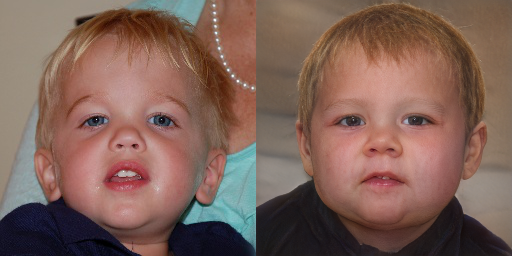

In [42]:
t = tensor2img(x[0])
p = tensor2img(preds[0])
res = get_concat_h(t, p)
res